In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

# 0. Load data

In [2]:
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.shape

(1460, 81)

In [4]:
X_train = data.drop('SalePrice', axis=1)
y_train = data['SalePrice']

In [5]:
X_train.shape

(1460, 80)

# 1. Exclude features with high missing value percentage

In [6]:
missing_values = (X_train.isna().sum()/X_train.shape[0])*100
missing_values = missing_values.sort_values(ascending=False)
missing_values.head(5)

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
FireplaceQu    47.260274
dtype: float64

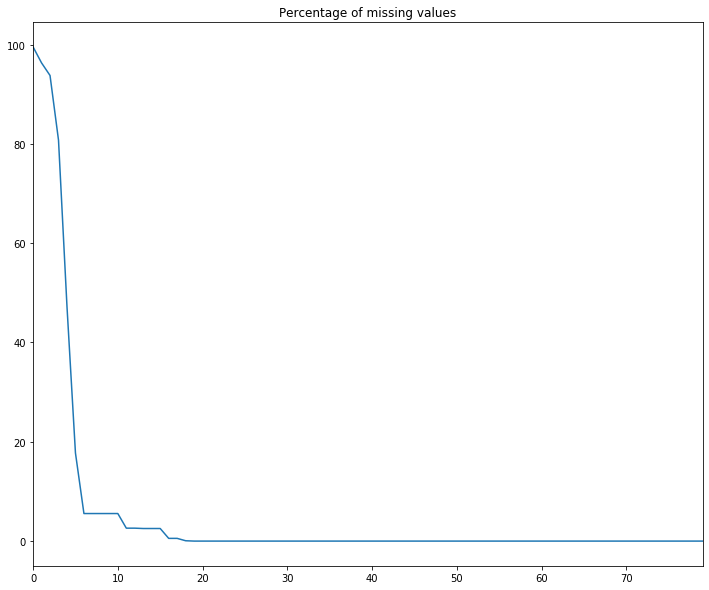

In [7]:
missing_values.plot(use_index=False, figsize=(12,10), title='Percentage of missing values')

In [8]:
col_missing = missing_values[missing_values > 5]
X_train = X_train.drop(col_missing.index, axis=1)
X_train.shape

(1460, 69)

# 2. Exclude features with low variance

In [9]:
data_var = pd.DataFrame()
data_var['value'] = X_train.var()
data_var.sort_values(by='value', inplace=True, ascending=True)
col_low_var = list(data_var[data_var['value'] < 0.1].index.values)
col_low_var

['KitchenAbvGr', 'BsmtHalfBath']

In [10]:
data['KitchenAbvGr'].value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [11]:
data['BsmtHalfBath'].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [12]:
X_train = X_train.drop(col_low_var, axis=1)
X_train.shape

(1460, 67)

# 3. Impute missing values

- For numerical columns, missing values will be replaced by median
- For object columns, missing values will be replaced by the most frequent value

In [13]:
((X_train.isna().sum()/X_train.shape[0])*100).sort_values(ascending=False).head(10)

BsmtFinType2    2.602740
BsmtExposure    2.602740
BsmtQual        2.534247
BsmtCond        2.534247
BsmtFinType1    2.534247
MasVnrArea      0.547945
MasVnrType      0.547945
Electrical      0.068493
Street          0.000000
RoofStyle       0.000000
dtype: float64

In [14]:
for col in X_train.select_dtypes(exclude=['object']).columns:
        X_train[col].fillna(X_train[col].median(), inplace = True)
for col in X_train.select_dtypes(include=['object']).columns: 
        X_train[col].fillna(X_train[col].value_counts().idxmax(), inplace = True)

# 4. Encode categorical variables

- Factorize values - enumerate categories
    - E.g. `Street (Grvl, Pave) -> 0, 1`
- Create dummy variables - convert categorical variable into dummy/indicator variables
    - E.g. `Street (Grvl, Pave) -> Street_Grvl, Street_Pave`

In [15]:
data_encoded = X_train
encoding_table = [['feature', 'encoded_labels']]
    
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        labels, uniques = pd.factorize(data_encoded[col])
        data_encoded[col] = labels
        encoding_table.append([col, ", ".join(list(uniques))])
pd.DataFrame(encoding_table[1:], columns=encoding_table[0])

,feature,encoded_labels
0,MSZoning,"RL, RM, C (all), FV, RH"
1,Street,"Pave, Grvl"
2,LotShape,"Reg, IR1, IR2, IR3"
3,LandContour,"Lvl, Bnk, Low, HLS"
4,Utilities,"AllPub, NoSeWa"
5,LotConfig,"Inside, FR2, Corner, CulDSac, FR3"
6,LandSlope,"Gtl, Mod, Sev"
7,Neighborhood,"CollgCr, Veenker, Crawfor, NoRidge, Mitchel, Somerst, NWAmes, OldTown, BrkSide, Sawyer, NridgHt, NAmes, SawyerW, IDOTRR, MeadowV, Edwards, Timber, Gilbert, StoneBr, ClearCr, NPkVill, Blmngtn, BrDale, SWISU, Blueste"
8,Condition1,"Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, PosA, RRNe"
9,Condition2,"Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, RRAe"


In [16]:
X_train.shape

(1460, 67)

# 5. Exclude collinear (highly-correlated) variables 

In [17]:
threshold = 0.7
highly_cor_col = []
col_corr = set()
correlation_matrix = X_train.corr()
correlated_cols = [['column1', 'column2', 'corr_coeff']]
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_cols.append([
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ])
        if (abs(correlation_matrix.iloc[i, j]) >= threshold) and (correlation_matrix.columns[j] not in col_corr): 
            col_corr.add(colname)
            if colname in X_train.columns:
                highly_cor_col.append(colname)
            
correlated_cols_df = pd.DataFrame(correlated_cols[1:], columns=correlated_cols[0])
correlated_cols_df.sort_values(by='corr_coeff', ascending=False).head()

,column1,column2,corr_coeff
5,GarageArea,GarageCars,0.882475
4,TotRmsAbvGrd,GrLivArea,0.825489
3,1stFlrSF,TotalBsmtSF,0.819530
0,BldgType,MSSubClass,0.770840
1,Exterior2nd,Exterior1st,0.749599


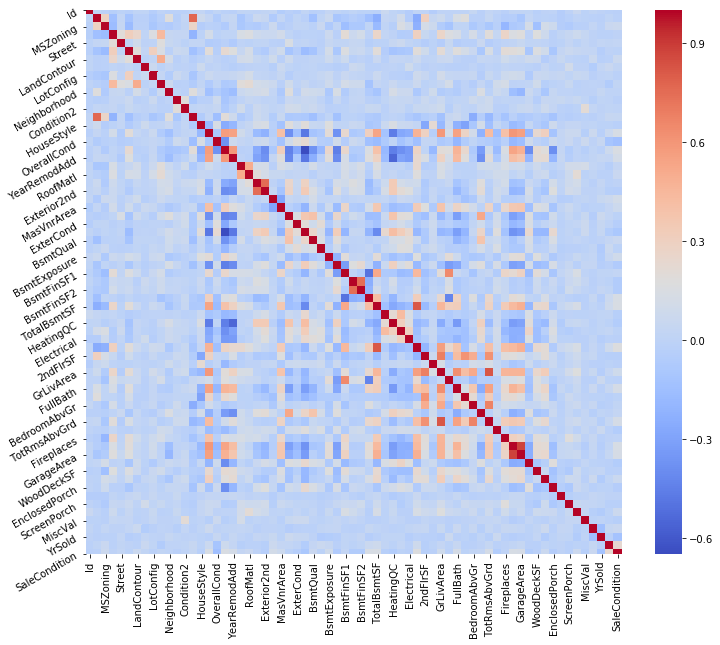

In [18]:
plt.figure(figsize=(12, 10))
s=sns.heatmap(X_train.corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=10)
s.set_xticklabels(s.get_xticklabels(),rotation=90,fontsize=10)
plt.show()

In [19]:
highly_cor_col

['BldgType',
 'Exterior2nd',
 'BsmtFinSF2',
 '1stFlrSF',
 'TotRmsAbvGrd',
 'GarageArea']

In [20]:
X_train = X_train.drop(highly_cor_col, axis=1)
X_train.shape

(1460, 61)

# 6. Correlation with target variable

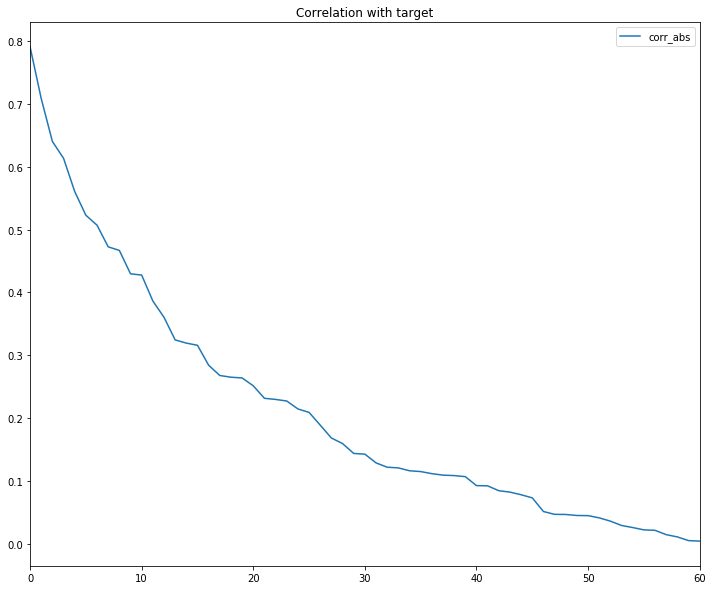

In [21]:
corr_target = []
corr_target2 = []

for var in X_train.columns:
    corr_target.append(abs(y_train.corr(X_train[var])))
    corr_target2.append(y_train.corr(X_train[var]))
corr_target_df = pd.DataFrame(
    corr_target, X_train.columns, columns=['corr_abs']
)
corr_target_df['corr'] = corr_target2
corr_target_df = corr_target_df.sort_values(by='corr_abs', ascending=False)

corr_target_df.plot(y='corr_abs', use_index=False, figsize=(12,10), title='Correlation with target')

#  Principal component analysis

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


#In general it is a good idea to scale the data
X_scaled = StandardScaler().fit_transform(X_train.values)

pca = PCA()
pca.fit(X_scaled,y_train.values)
x_new = pca.transform(X_scaled)   

In [23]:
# How many percent of variance are explaind by the first two PCs
pca.explained_variance_ratio_[:2]

array([0.12054003, 0.05503257])

In [24]:
len(pca.components_[1])

61

In [25]:
pca.components_[:2]

array([[-0.00406725,  0.00280722, -0.03412148,  0.06813777, -0.01819319,
         0.11791791,  0.00871211, -0.00464648,  0.03897211, -0.00591404,
        -0.07169872, -0.01899673, -0.00669264, -0.10514018,  0.29624935,
        -0.07178516,  0.29503699,  0.25561083,  0.02077229,  0.01736515,
        -0.09848076, -0.03338002,  0.16497353, -0.19756965, -0.08678997,
        -0.24756014, -0.11557658, -0.06472157,  0.10128349, -0.18119285,
         0.12881291, -0.03149924,  0.09432097,  0.22022352, -0.08676275,
        -0.216355  , -0.15995819, -0.14813094,  0.10968915, -0.04015516,
         0.22331223,  0.085317  ,  0.23984131,  0.13072734,  0.05480602,
        -0.15374328, -0.05975925,  0.14661142,  0.25980029, -0.13356433,
         0.13003087,  0.13001599, -0.10211909,  0.01618575,  0.01440299,
         0.0288549 , -0.01645809,  0.0198771 , -0.01413845,  0.01912241,
         0.05533628],
       [-0.0056632 , -0.09336664, -0.16538366,  0.30938967,  0.08728403,
         0.16343338,  0.19409

In [26]:
loadings_df = pd.DataFrame(pca.components_[0],  X_train.columns, columns=['PC1'])
loadings_df['PC2'] = pca.components_[1]
loadings_df.head()

,PC1,PC2
Id,-0.004067,-0.005663
MSSubClass,0.002807,-0.093367
MSZoning,-0.034121,-0.165384
LotArea,0.068138,0.309390
Street,-0.018193,0.087284


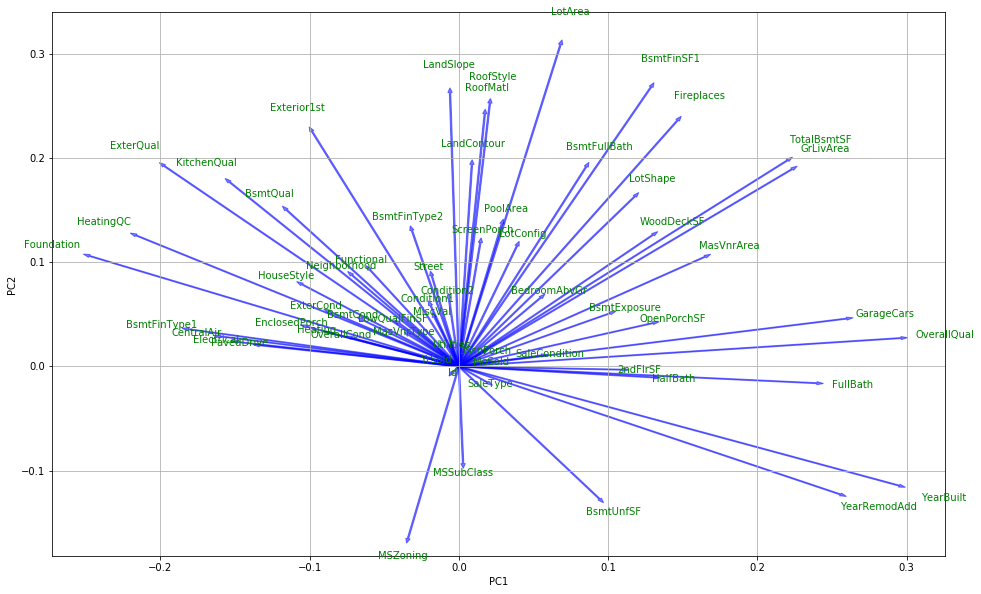

In [27]:
plt.figure(figsize=(16, 10))
plt.xlim(
    loadings_df['PC1'].min() + loadings_df['PC1'].min()/10,
    loadings_df['PC1'].max() + loadings_df['PC1'].max()/10
)
plt.ylim(
    loadings_df['PC2'].min() + loadings_df['PC2'].min()/10,
    loadings_df['PC2'].max() + loadings_df['PC2'].max()/10
)
for i in range(loadings_df.shape[0]):
        plt.arrow(0, 0, loadings_df.iloc[i, 0], loadings_df.iloc[i, 1],color = 'b',alpha = 0.5)
        plt.text(
            loadings_df.iloc[i, 0]* 1.1, loadings_df.iloc[i, 1] * 1.1, 
            loadings_df.index[i], color = 'g', ha = 'center', va = 'center'
        )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid() 